In [1]:
#In this notebook i try to visualize RNN with attention mechnanism
#Base code is at : https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html
#I change the code to log all intermediate steps
#So you can see

In [2]:
import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
from torchtext.datasets import Multi30k
from torchtext.data import Field, BucketIterator

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import spacy
import numpy as np
import matplotlib

import random
import math
import time
import random
from yellowbrick.text import TSNEVisualizer
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import seaborn as sns
import os.path


In [3]:
%matplotlib inline

In [4]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
#---------- Attention Types
#according to these values i create attention vectors and change the 
#work flow of network
ATTENTION_DEFAULT = 1
ATTENTION_EQUAL_DISTRIBUTED = 2
ATTENTION_AT_BEGINNING = 3
ATTENTION_AT_END = 4

In [6]:
#utility class to log all intermediate steps
#here saving all tensors send to add_info
#then we can query these tensors. When we want to have a seperate logger, create new instance.

class StepLogger():
    def __init__(self,capacity):
        self.tensor_datas = {}        
        self.capacity = capacity
        self.added_labels = []
        
    
    def add_info(self,tensor_data,tensor_label):
        if tensor_label not in self.added_labels:
            self.added_labels.append( tensor_label )
        
        if tensor_label in self.tensor_datas.keys():
            current_arr = self.tensor_datas.get(tensor_label)
            if len(current_arr) < self.capacity:
                current_arr = self.tensor_datas.get(tensor_label, [])
                current_arr.append(tensor_data)
        else:
            self.tensor_datas[tensor_label] = [tensor_data]
    
    def get_default_summary(self,show_data=False,summary_count=1):
        self.get_summary(self.added_labels,show_data,show_info=True,summary_count=summary_count)
        
    def get_summary(self,labels,show_data=False,show_info=False,summary_count=1):
        if show_info:
            print("summary_count",summary_count,"   self.capacity ",self.capacity)
        count = 0
        values = []
        for i in range(summary_count):
            #print(i," ------------------------------------------------")
            for l in labels:
                if i < len(self.tensor_datas.get(l)):
                    label_data = self.tensor_datas.get(l)[i]
                    values.append(label_data)
                    if show_info:
                        print(l)
                    if torch.is_tensor(label_data):
                        if show_info:
                            print( list(label_data.size() ) )
                    if not show_data and not torch.is_tensor(label_data):
                        if show_info:
                            print(label_data)
                    if show_data:    
                        print(label_data)
        return values              
                    
loggers = {}                    
current_logger = StepLogger(100)   
def add_new_logger(logger_label):
    global current_logger
    if logger_label in loggers.keys() :
        #print("using existing logger")
        current_logger = loggers[logger_label]
    else:    
        loggers[logger_label]  = StepLogger(50)
        current_logger = loggers[logger_label]
    

def add_infos(datas,labels,labels_prefix=""):
    #print( id(current_logger))
    for i in range(len(datas)):
        final_label = labels_prefix+"@"+labels[i]
        current_logger.add_info(datas[i],final_label.strip())
    
#add_info   tensor_data,tensor_label                  currentLogger.get_default_summary(show_data=False)


    

In [7]:
def tokenize(text):
    return [tok for tok in text.split(" ")]

SRC = Field(tokenize = tokenize, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)

TRG = Field(tokenize = tokenize, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)

#read csv file
tabular_set = torchtext.data.TabularDataset(
path='D:/nnmedium/eng_de.csv', format='csv',
fields=[('src', SRC),('trg', TRG)])

In [8]:
SRC.build_vocab(tabular_set, min_freq = 2)
TRG.build_vocab(tabular_set, min_freq = 2)

In [9]:
pairs = []
for i in range(len(tabular_set)):
    pairs.append( [ " ".join(tabular_set[i].src), " ".join(tabular_set[i].trg) ])
pairs    

[['i want to eat bread', 'ich mochten brot essen'],
 ['i want to eat apple', 'ich mochten apfel essen'],
 ['i want to drink water', 'ich mochten wasser trinken'],
 ['i want to drink beer', 'ich mochten bier trinken'],
 ['i want to read book', 'ich mochten buch lesen'],
 ['i want to read newspaper', 'ich mochten zeitung lesen'],
 ['i can eat bread', 'ich konnen brot essen'],
 ['i can eat apple', 'ich konnen apfel essen'],
 ['i can drink water', 'ich konnen wasser trinken'],
 ['i can drink beer', 'ich konnen bier trinken'],
 ['i can read book', 'ich konnen buch lesen'],
 ['i can read newspaper', 'ich konnen zeitung lesen'],
 ['we want to eat bread', 'wir mochten brot essen'],
 ['we want to eat apple', 'wir mochten apfel essen'],
 ['we want to drink water', 'wir mochten wasser trinken'],
 ['we want to drink beer', 'wir mochten bier trinken'],
 ['we want to read book', 'wir mochten buch lesen'],
 ['we want to read newspaper', 'wir mochten zeitung lesen'],
 ['we can eat bread', 'wir konnen 

In [10]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [11]:
MAX_LENGTH = 8
def prepareData(lang1, lang2, reverse=False):
    input_lang = Lang(lang1)
    output_lang = Lang(lang2)
    
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('eng', 'ger', False)
print(random.choice(pairs))

Counted words:
eng 16
ger 15
['we drink water', 'wir trinken wasser']


In [12]:
print(random.choice(pairs))

['we can read book', 'wir konnen buch lesen']


In [13]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        add_infos([input,output,hidden],["input","output","hidden"],"EncoderRNN") 
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [14]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    
    def forward(self, input, hidden, encoder_outputs,attention_type):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),encoder_outputs.unsqueeze(0))
        
        if attention_type == ATTENTION_EQUAL_DISTRIBUTED:
            equal_attention = torch.tensor(np.ones(attn_weights.shape).astype(np.float32) )
            attn_weights = equal_attention
            attn_applied = torch.bmm(attn_weights.unsqueeze(0),encoder_outputs.unsqueeze(0))
        
        if attention_type == ATTENTION_AT_END:
            equal_at_end = torch.tensor(np.ones(attn_weights.shape).astype(np.float32) )
            equal_at_end[0][equal_at_end.shape[1]-1] = 1
            attn_weights = equal_at_end
            attn_applied = torch.bmm(attn_weights.unsqueeze(0),encoder_outputs.unsqueeze(0))
            

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        #log these vectors
        add_infos([output,attn_weights,attn_applied],["output","attn_weights","attn_applied"],"AttnDecoderRNN") 
        
        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights
            
    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [15]:
def indexesFromSentence(lang, sentence):
    if isinstance(sentence,list):
        return [lang.word2index[word] for word in sentence]
    else:    
        return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [16]:
#train the network
def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, 
          criterion,attention_type, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = False

    for di in range(target_length):
        
        decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs, attention_type)
        topv, topi = decoder_output.topk(1)
        decoder_input = topi.squeeze().detach()  # detach from history as input

        loss += criterion(decoder_output, target_tensor[di])
        if decoder_input.item() == EOS_token:
            break
            

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [17]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [18]:
import gc

def trainIters(encoder, decoder, n_iters,attention_type, print_every=1000, plot_every=100, learning_rate=0.01):
    gc.collect()
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion,attention_type)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [19]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [20]:


def translate_sentence(attention_type,encoder, decoder, sentence, max_length=MAX_LENGTH):
    return evaluate(attention_type,encoder, decoder, sentence, max_length)

def evaluate(attention_type,encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()        

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],encoder_hidden)            
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS
        decoder_hidden = encoder_hidden
        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        all_outputs = []
        for di in range(max_length):
            #print("attention_type",attention_type)
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, 
                                                                        encoder_outputs,attention_type)            
            decoder_attentions[di] = decoder_attention.data            
            topv, topi = decoder_output.data.topk(1)            
            all_outputs.append(decoder_output)
            
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()            

        return decoded_words, decoder_attentions[:di + 1],all_outputs

In [21]:
def evaluateRandomly(encoder, decoder, n=5):
    for i in range(n):
        pair = random.choice(pairs)
        print('input     ->', pair[0])
        print('expected  ->', pair[1])
        output_words, attentions,all_outputs = evaluate(ATTENTION_DEFAULT,encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('predicted ->', output_sentence)
        print('')

def indexes_to_word(lang,indexes):
    return " ".join( [lang.index2word[i]  for i in torch.flatten(indexes).numpy() ] )        

In [22]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

#trainIters(encoder1, attn_decoder1, 1000, print_every=500)

In [23]:
print( encoder1)

EncoderRNN(
  (embedding): Embedding(16, 256)
  (gru): GRU(256, 256)
)


In [24]:
print( attn_decoder1)

AttnDecoderRNN(
  (embedding): Embedding(15, 256)
  (attn): Linear(in_features=512, out_features=8, bias=True)
  (attn_combine): Linear(in_features=512, out_features=256, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (gru): GRU(256, 256)
  (out): Linear(in_features=256, out_features=15, bias=True)
)


0m 3s (- 1m 41s) (100 3%) 1.7688
0m 7s (- 1m 50s) (200 6%) 1.4318
0m 11s (- 1m 45s) (300 10%) 1.0347
0m 15s (- 1m 38s) (400 13%) 0.5550
0m 18s (- 1m 33s) (500 16%) 0.2350
0m 23s (- 1m 33s) (600 20%) 0.1221
0m 26s (- 1m 26s) (700 23%) 0.0670
0m 29s (- 1m 20s) (800 26%) 0.0454
0m 32s (- 1m 15s) (900 30%) 0.0290
0m 35s (- 1m 10s) (1000 33%) 0.0222
0m 37s (- 1m 5s) (1100 36%) 0.0179
0m 40s (- 1m 1s) (1200 40%) 0.0153
0m 43s (- 0m 57s) (1300 43%) 0.0125
0m 46s (- 0m 53s) (1400 46%) 0.0107
0m 49s (- 0m 49s) (1500 50%) 0.0090
0m 52s (- 0m 46s) (1600 53%) 0.0082
0m 56s (- 0m 43s) (1700 56%) 0.0075
1m 0s (- 0m 40s) (1800 60%) 0.0071
1m 4s (- 0m 37s) (1900 63%) 0.0062
1m 6s (- 0m 33s) (2000 66%) 0.0059
1m 9s (- 0m 29s) (2100 70%) 0.0057
1m 12s (- 0m 26s) (2200 73%) 0.0048
1m 15s (- 0m 23s) (2300 76%) 0.0045
1m 18s (- 0m 19s) (2400 80%) 0.0041
1m 21s (- 0m 16s) (2500 83%) 0.0040
1m 24s (- 0m 13s) (2600 86%) 0.0037
1m 27s (- 0m 9s) (2700 90%) 0.0035
1m 30s (- 0m 6s) (2800 93%) 0.0035
1m 33s (- 0m 

<Figure size 432x288 with 0 Axes>

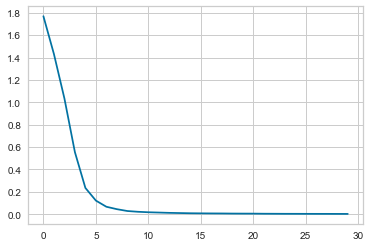

In [25]:
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)
    
trainIters(encoder1, attn_decoder1, n_iters=3000,attention_type=ATTENTION_DEFAULT, print_every=100)

#evaluateRandomly(encoder1, attn_decoder1)   

In [26]:
#if you train less, u can see network will not generate correct results
#encoder1000 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
#attn_decoder1000 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)
    
#trainIters(encoder1000, attn_decoder1000, n_iters=1000,attention_type=ATTENTION_DEFAULT, print_every=100)
#evaluateRandomly(encoder1000, attn_decoder1000)

In [27]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions, all_outputs = evaluate(ATTENTION_DEFAULT,
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)

In [28]:
#evaluateAndShowAttention("i can eat apple")

In [29]:
#evaluateAndShowAttention("i can eat apple")

In [30]:
print(attn_decoder1)

AttnDecoderRNN(
  (embedding): Embedding(15, 256)
  (attn): Linear(in_features=512, out_features=8, bias=True)
  (attn_combine): Linear(in_features=512, out_features=256, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (gru): GRU(256, 256)
  (out): Linear(in_features=256, out_features=15, bias=True)
)


In [31]:
def display_attention(sentence, translation, attention, n_heads = 1, n_rows = 1, n_cols = 1):
    
    assert n_rows * n_cols == n_heads
    figsize = (5,5) if n_cols == 1 else (15,15)
    fig = plt.figure(figsize=figsize) 
    
    for i in range(n_heads):
        
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        
        _attention = attention.cpu().detach().numpy()        

        cax = ax.matshow(_attention, cmap='bone')

        ax.tick_params(labelsize=12)
        xticklabels = ['']+[t.lower() for t in sentence.split(" ")]+['<eos>']
        ax.set_xticklabels(xticklabels,  rotation=45)
        
        ax.set_yticklabels(['']+translation)

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close() 

def translate_info(src,draw_charts,attention_type,dump_result=True,flow_type=1):
    
    
    logger_name = "".join(src)+str( random.randint(1,180001) )
    add_new_logger(logger_name)
    if dump_result:
        print(f'source = {src}')

    translation, attention,all_outputs = evaluate(attention_type,encoder1, attn_decoder1, src)
    #translate_sentence(src, model, device,attention_type=attention_type,flow_type=flow_type)

    if dump_result:
        print(f'predicted target = {translation}')
    output_words = translation
    
    
    indexes = []
    for index_w,w in enumerate(translation):
        if index_w == 0:
            indexes.append("sos->"+w.replace("<","").replace(">",""))
        else:    
            indexes.append(translation[index_w -1 ]+"->"+w.replace("<","").replace(">",""))        
    
    indexes = [ str(i+1)+")"+index for i,index in enumerate(indexes) ]
    #for better display i do not include "unk","pad",    
    all_outputs = np.array( torch.cat( all_outputs ) )
    #print("all_outputs shape",all_outputs.shape)
    df2 = pd.DataFrame(all_outputs,columns=output_lang.index2word.values(),index=indexes)
    
    pd.options.display.float_format = '{:,.2f}'.format
    cm = sns.light_palette("blue", as_cmap=True)
    
    df2.style.format("{:.2%}")
    
    df2.style.set_table_attributes("style='display:inline'").set_caption('Logits for translation')
    styled_df = df2.style.background_gradient(cmap=cm).set_precision(2)     
    
    pd.options.display.float_format = '{:,.2f}'.format
    if draw_charts:
        print("Logits")
        #print("attention",attention)
        display(styled_df)    
        display_attention(src, indexes, attention,n_heads=1,n_rows = 1, n_cols = 1)
    return loggers[logger_name],all_outputs,translation

source = we can eat apple
predicted target = ['wir', 'konnen', 'apfel', 'essen', '<EOS>']
Logits


,SOS,EOS,ich,mochten,brot,essen,apfel,wasser,trinken,bier,buch,lesen,zeitung,konnen,wir
1)sos->wir,-13.56,-20.63,-7.36,-14.21,-15.75,-11.93,-11.40,-17.67,-14.40,-14.69,-16.52,-15.02,-17.11,-7.49,-0.00
2)wir->konnen,-13.09,-25.28,-11.83,-6.28,-14.21,-6.34,-8.92,-16.39,-11.82,-14.03,-16.22,-12.49,-15.47,-0.00,-8.75
3)konnen->apfel,-11.01,-16.68,-12.07,-12.11,-5.42,-7.54,-0.01,-10.00,-15.73,-7.73,-7.82,-13.82,-8.01,-8.64,-9.53
4)apfel->essen,-12.29,-6.49,-13.40,-13.19,-11.06,-0.00,-6.87,-15.06,-8.91,-12.64,-14.02,-8.75,-14.28,-10.85,-11.73
5)essen->EOS,-13.18,-0.00,-15.40,-20.40,-10.51,-9.78,-7.69,-13.65,-13.58,-11.85,-12.42,-13.51,-13.09,-18.57,-14.24


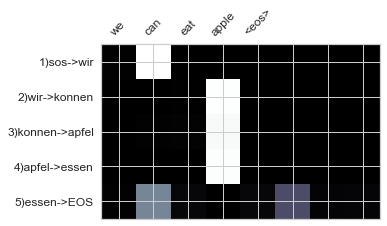

In [32]:
_ = translate_info("we can eat apple",attention_type=ATTENTION_DEFAULT,draw_charts=True)


source = we can eat apple
predicted target = ['wir', 'essen', 'apfel', 'essen', '<EOS>']
Logits


,SOS,EOS,ich,mochten,brot,essen,apfel,wasser,trinken,bier,buch,lesen,zeitung,konnen,wir
1)sos->wir,-13.13,-14.01,-11.27,-16.79,-12.44,-6.32,-7.51,-17.89,-13.67,-13.47,-14.97,-13.84,-16.49,-10.54,-0.00
2)wir->essen,-12.62,-14.43,-14.29,-13.57,-12.11,-0.01,-7.15,-17.20,-9.03,-13.41,-15.89,-10.01,-16.25,-5.49,-4.84
3)essen->apfel,-9.53,-2.01,-11.70,-16.84,-5.23,-1.85,-0.46,-11.63,-10.14,-8.16,-9.09,-10.68,-10.59,-10.90,-2.65
4)apfel->essen,-13.72,-2.23,-16.68,-18.82,-12.57,-0.11,-8.23,-17.44,-8.70,-14.13,-16.38,-10.81,-17.40,-13.54,-8.64
5)essen->EOS,-14.22,-0.00,-17.65,-23.15,-10.95,-5.92,-6.95,-16.69,-13.36,-13.47,-14.63,-14.55,-16.10,-18.07,-9.75


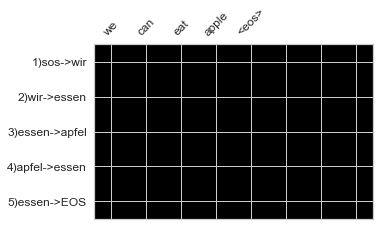

In [33]:
_ = translate_info("we can eat apple",attention_type=ATTENTION_EQUAL_DISTRIBUTED,draw_charts=True)

In [34]:
def get_translate_trg_vector(index,attention_type,filter_words):
    sentences = [ " ".join( tabular_set[i].src) for i in range(len(tabular_set)) ]
    filtered_sentences = []    
    sentences_embeddings = []
    step_output_words = []
    for i in range(len(tabular_set)):
        test_logger,all_outputs,output_words = translate_info(tabular_set[i].src,attention_type=attention_type,draw_charts=False,dump_result=False)
        trg4 = test_logger.get_summary(labels=["AttnDecoderRNN@output"],show_data=False,summary_count=10)        
        if len( trg4 ) > index : #because of length of sentence,positions do no match just do this for same size items
            if output_words[index] in filter_words:
                sentences_embeddings.append(trg4[index].numpy().flatten())
                filtered_sentences.append( sentences[i] )            
                step_output_words.append(output_words[index])            
    return sentences_embeddings,filtered_sentences,step_output_words

In [35]:
attention_type = ATTENTION_DEFAULT
test_logger,all_outputs,output_words = translate_info(tabular_set[i].src,attention_type=attention_type,draw_charts=False,dump_result=False)
trg4 = test_logger.get_summary(labels=["AttnDecoderRNN@output"],show_data=False,summary_count=10)
#trg4[4].squeeze().shape
len(trg4)

4

In [36]:
def show_embeddings(invalid_embeddings,invalid_sentences,valid_sentences_embeddings,valid_sentences,fig_size=[18,8]):    
    Xs = valid_sentences_embeddings
    Ys = valid_sentences
   
    #I want to mark sentences 
    if len(invalid_sentences)> 0 :
        invalid_sentences = [ "<<<"+s+">>>" for s in invalid_sentences]
        Xs = Xs+ [embed for embed in invalid_embeddings]
        Ys = Ys + invalid_sentences 
            
    pca = PCA(n_components=2)
    result = pca.fit_transform(np.array(Xs))

    fig = matplotlib.pyplot.gcf()
    fig.set_size_inches(fig_size[0], fig_size[1])

    #scatter result words
    plt.scatter(result[:, 0], result[:, 1])
    words = list(Ys)
    #put an annotation on x,y cordinates for words, color according to verb
    for i, word in enumerate(words):
        if word in invalid_sentences:
            if "eat" in word:
                plt.annotate(word.replace("<<<","").replace(">>>","!!!"), xy=(result[i, 0], result[i, 1]),color='#dd00dd')
            elif "drink" in word:
                plt.annotate(word.replace("<<<","").replace(">>>","]]]"), xy=(result[i, 0], result[i, 1]),color='#dd44dd')
            else:
                plt.annotate(word.replace("<<<",""), xy=(result[i, 0], result[i, 1]),color='#dd88dd')
        elif "eat" in word:
            plt.annotate(word, xy=(result[i, 0], result[i, 1]),color='#0000ff')
        elif "drink" in word:
            plt.annotate(word, xy=(result[i, 0], result[i, 1]),color='#00ff00')
        elif "read" in word:
            plt.annotate(word, xy=(result[i, 0], result[i, 1]),color='#ff0000')     
        else:
            plt.annotate(word, xy=(result[i, 0], result[i, 1]),color='#ff00dd')
    plt.show()    
    
    



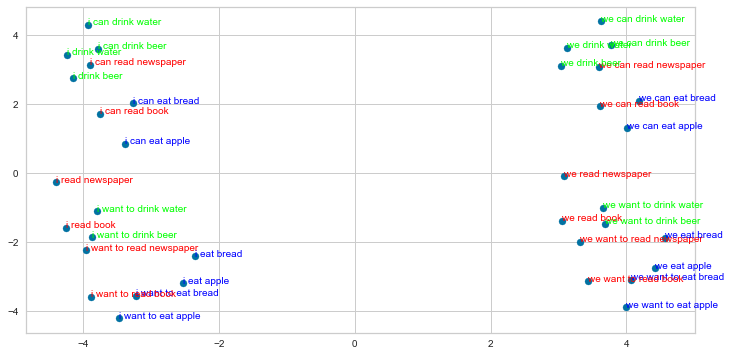

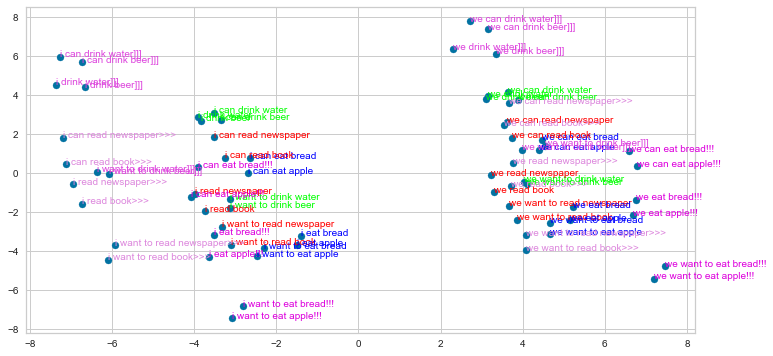

In [37]:
word_index_target = 0
filter_words = ["ich","wir"]
v_embeddings,v_sentences,v_outputs= get_translate_trg_vector( 
    word_index_target,ATTENTION_DEFAULT,filter_words)
show_embeddings([],[],v_embeddings,v_sentences,fig_size=[12,6])
inv_embeddings,inv_sentences,inv_outputs=get_translate_trg_vector( 
    word_index_target,ATTENTION_EQUAL_DISTRIBUTED,filter_words)
show_embeddings(inv_embeddings,inv_sentences,v_embeddings,v_sentences,fig_size=[12,6])

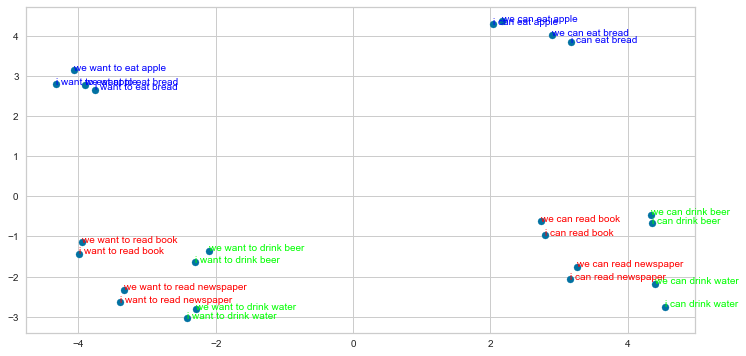

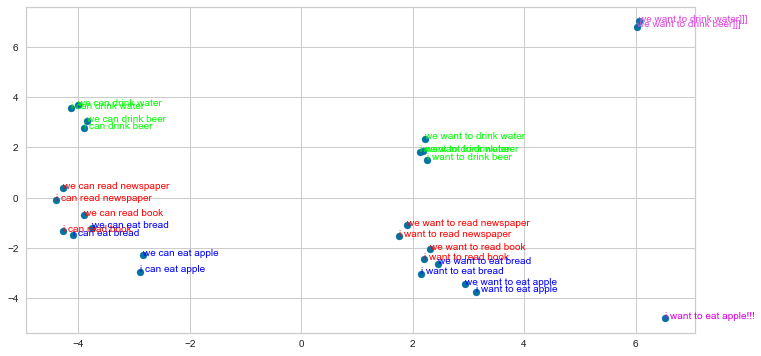

In [38]:
word_index_target = 1
filter_words = ["konnen","mochten"]
v_embeddings,v_sentences,v_outputs= get_translate_trg_vector( 
    word_index_target,ATTENTION_DEFAULT,filter_words)
show_embeddings([],[],v_embeddings,v_sentences,fig_size=[12,6])
inv_embeddings,inv_sentences,inv_outputs=get_translate_trg_vector( 
    word_index_target,ATTENTION_EQUAL_DISTRIBUTED,filter_words)
show_embeddings(inv_embeddings,inv_sentences,v_embeddings,v_sentences,fig_size=[12,6])

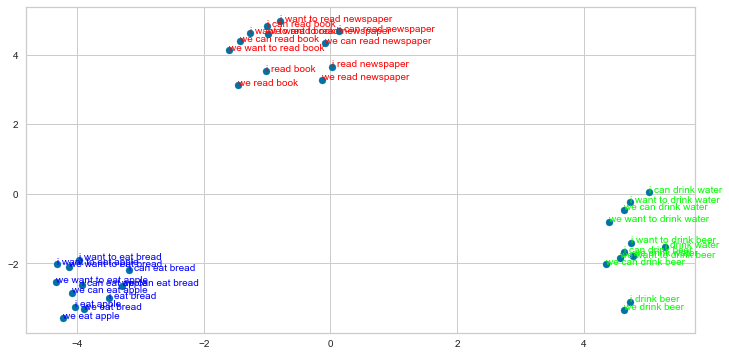

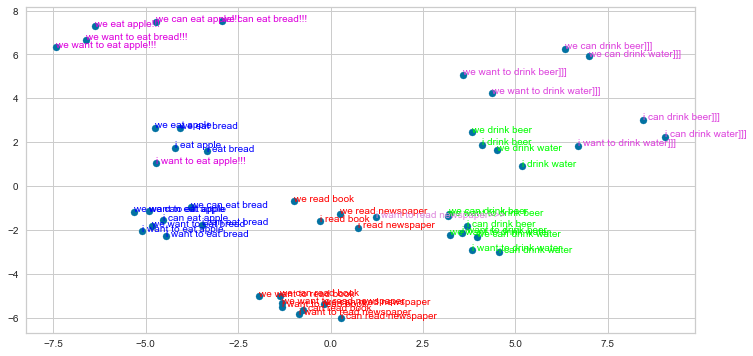

In [39]:
word_index_target = 2
filter_words = ["apfel","brot","buch","zeitung","wasser","bier"]
v_embeddings,v_sentences,v_outputs= get_translate_trg_vector( 
    word_index_target,ATTENTION_DEFAULT,filter_words)
show_embeddings([],[],v_embeddings,v_sentences,fig_size=[12,6])
inv_embeddings,inv_sentences,inv_outputs=get_translate_trg_vector( 
    word_index_target,ATTENTION_EQUAL_DISTRIBUTED,filter_words)
show_embeddings(inv_embeddings,inv_sentences,v_embeddings,v_sentences,fig_size=[12,6])

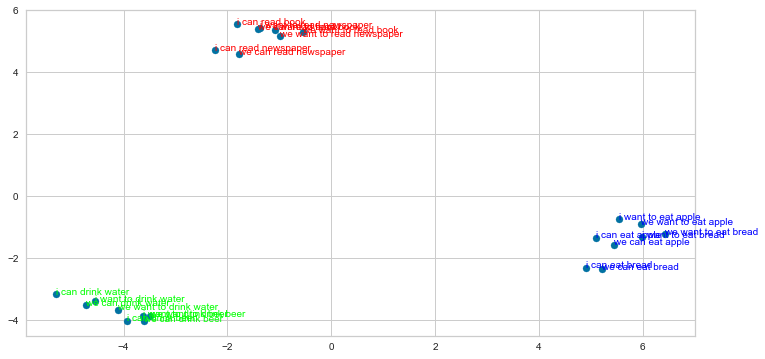

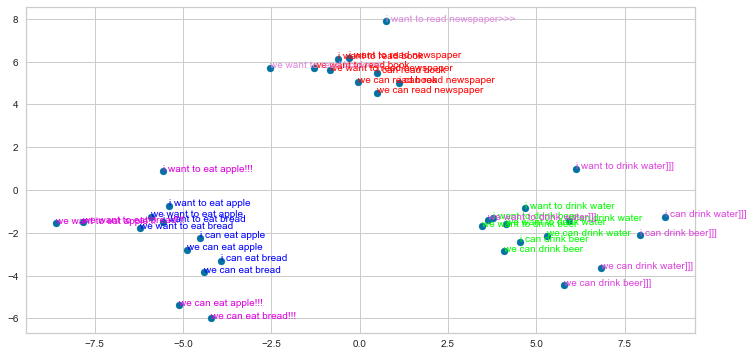

In [40]:
word_index_target = 3
filter_words = ["essen","lesen","trinken"]
v_embeddings,v_sentences,v_outputs= get_translate_trg_vector( 
    word_index_target,ATTENTION_DEFAULT,filter_words)
show_embeddings([],[],v_embeddings,v_sentences,fig_size=[12,6])
inv_embeddings,inv_sentences,inv_outputs=get_translate_trg_vector( 
    word_index_target,ATTENTION_EQUAL_DISTRIBUTED,filter_words)
show_embeddings(inv_embeddings,inv_sentences,v_embeddings,v_sentences,fig_size=[12,6])